In [2]:
%matplotlib widget

#from IPython import display
from base64 import b64decode
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

varPrefixes=["t", "soc", "d", "c", "u", "r", "temp"]
epsilon = 1e-3

## Science & Communication viewpoint modeling

### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function has no science or communication effect.


In [4]:
charging1_science = nochangeContract(s=2, name="u").merge(nochangeContract(s=4, name="r"))
print(f"charging1_science:\n\n{charging1_science}")

charging1_science:

InVars: [u2_entry, r4_entry]
OutVars:[u2_exit, r4_exit]
A: [
]
G: [
  -u2_entry + u2_exit = 0.0
  -r4_entry + r4_exit = 0.0
]


### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the downlinked data volume increases proportionally to a downlink speed.

Contract dsn1_data:

InVars: [d1_entry, duration_dsn1]
OutVars:[d1_exit]
A: [
  -duration_dsn1 <= 0.0
  -d1_entry <= -1.0
]
G: [
  d1_entry - d1_exit - 5.5 duration_dsn1 <= 0.0
  -d1_entry + d1_exit + 5.2 duration_dsn1 <= 0.0
  -d1_exit <= 0.0
]


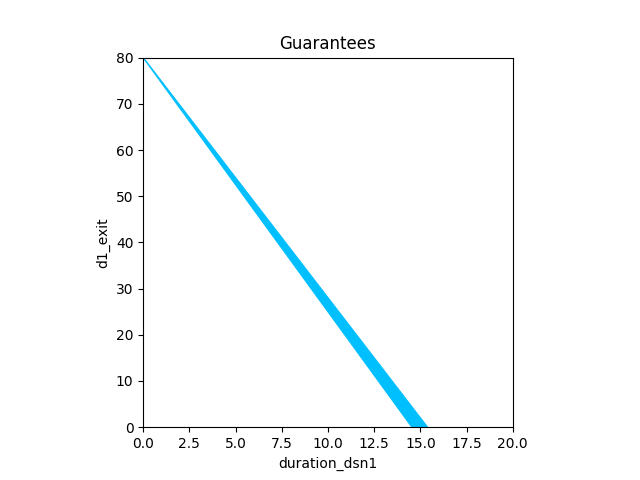

In [6]:
# - s: start index of the timeline variables
# - speed: (min, max) downlink rate during the task instance
# - epsilon: approximately zero
def DSN_data(s: int, speed: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"d{s}_entry",        # initial data volume
      f"duration_dsn{s}",   # variable task duration
    ],
    OutputVars = [
      f"d{s}_exit",          # final data volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_dsn{s} <= 0",

      # There is data to downlink: d{s} >= 1
      f"-d{s}_entry <= -1",
    ],
    guarantees = [
      # duration*speed(min) <= d{entry} - d{exit} <= duration*speed(max)
      f" d{s}_entry - d{s}_exit - {speed[1]}*duration_dsn{s} <= 0",
      f"-d{s}_entry + d{s}_exit + {speed[0]}*duration_dsn{s} <= 0",

      # downlink cannot continue if there is no data left.
      f"-d{s}_exit <= 0",
    ])
  return spec

dsn1_data = DSN_data(s=1, speed=(5.2, 5.5))
print(f"Contract dsn1_data:\n\n{dsn1_data}")

_ = plot_guarantees(contract=dsn1_data,
                x_var=Var("duration_dsn1"),
                y_var=Var("d1_exit"),
                var_values={
                  Var("d1_entry"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))